In [18]:
from utils import convert_hom_to_het, train, test, het_predict
from het_networks import HeteroCONV, HeteroGAT, HeteroSAGE

import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [20]:
het_dataset = []
for hom_data in hom_dataset_attr:
    het_dataset.append(convert_hom_to_het(hom_data, is_directed=False))
het_dataset.__len__()

600

In [21]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'connects', 'A'),
  ('A', 'connects', 'B'),
  ('A', 'connects', 'C'),
  ('B', 'connects', 'B'),
  ('B', 'connects', 'C'),
  ('C', 'connects', 'C')])

In [22]:
train_dataset, test_dataset = train_test_split(het_dataset, test_size=0.2)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [23]:
model = HeteroSAGE(metadata, 32, 32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
model.convs[0].convs

ModuleDict(
  (<A___connects___A>): SAGEConv((-1, -1), 32, aggr=mean)
  (<A___connects___B>): SAGEConv((-1, -1), 32, aggr=mean)
  (<A___connects___C>): SAGEConv((-1, -1), 32, aggr=mean)
  (<B___connects___B>): SAGEConv((-1, -1), 32, aggr=mean)
  (<B___connects___C>): SAGEConv((-1, -1), 32, aggr=mean)
  (<C___connects___C>): SAGEConv((-1, -1), 32, aggr=mean)
)

In [24]:
# Initialize tracking
metrics = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': [],
    'train_f1': [],
    'test_f1': []
}

best_val_loss = float('inf')
epochs = 15

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, device=device)
    test_loss, test_acc, test_f1 = test(model, test_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['test_loss'].append(test_loss)
    metrics['train_acc'].append(train_acc)
    metrics['test_acc'].append(test_acc)
    metrics['train_f1'].append(train_f1)
    metrics['test_f1'].append(test_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Test F1: {test_f1:.4f}\n")

Epoch 1/15
Train Loss: 2.4140 | Test Loss: 1.8972
Train Acc: 0.2062 | Test Acc: 0.2250
Train F1: 0.1393 | Test F1: 0.1111

Epoch 2/15
Train Loss: 1.8911 | Test Loss: 1.8023
Train Acc: 0.2167 | Test Acc: 0.3083
Train F1: 0.2080 | Test F1: 0.2111

Epoch 3/15
Train Loss: 1.8169 | Test Loss: 1.8096
Train Acc: 0.2437 | Test Acc: 0.1917
Train F1: 0.2435 | Test F1: 0.1173

Epoch 4/15
Train Loss: 1.7647 | Test Loss: 1.7794
Train Acc: 0.2625 | Test Acc: 0.2667
Train F1: 0.2670 | Test F1: 0.2235

Epoch 5/15
Train Loss: 1.7396 | Test Loss: 1.7450
Train Acc: 0.2396 | Test Acc: 0.3500
Train F1: 0.2288 | Test F1: 0.2850

Epoch 6/15
Train Loss: 1.7161 | Test Loss: 1.7635
Train Acc: 0.2583 | Test Acc: 0.3417
Train F1: 0.2565 | Test F1: 0.2758

Epoch 7/15
Train Loss: 1.7072 | Test Loss: 1.7406
Train Acc: 0.2562 | Test Acc: 0.3000
Train F1: 0.2397 | Test F1: 0.2192

Epoch 8/15
Train Loss: 1.6995 | Test Loss: 1.7474
Train Acc: 0.2521 | Test Acc: 0.3250
Train F1: 0.2321 | Test F1: 0.2985

Epoch 9/15
Train

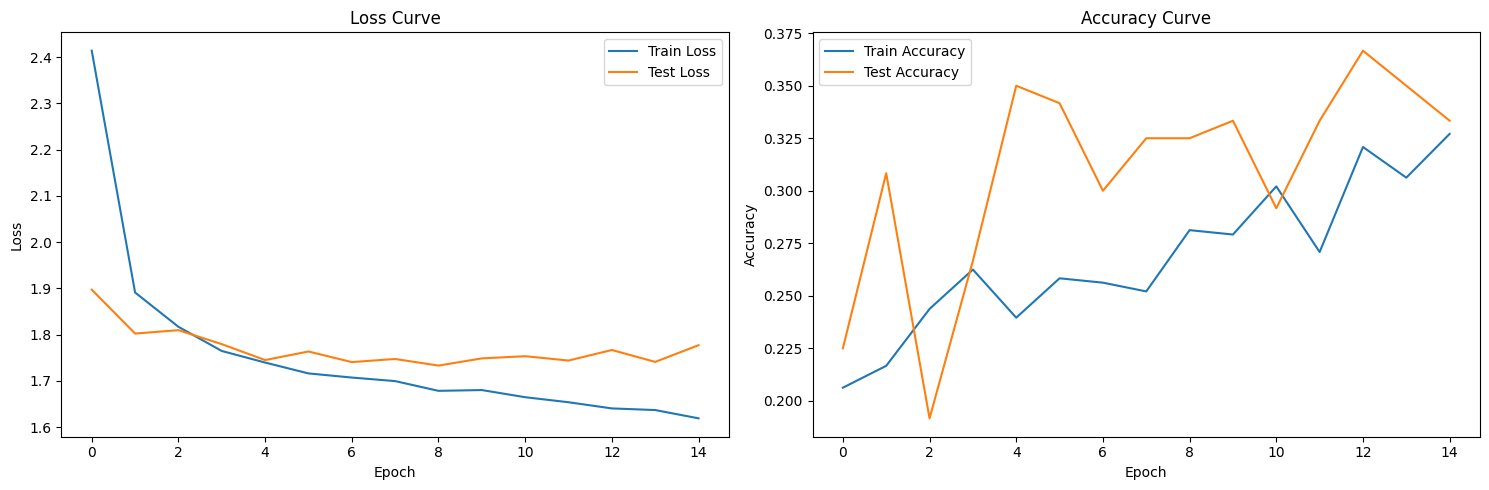

,Epoch,Train Loss,Test Loss,Train Acc,Test Acc,Train F1,Test F1
0,1,2.4140,1.8972,0.2062,0.2250,0.1393,0.1111
1,2,1.8911,1.8023,0.2167,0.3083,0.2080,0.2111
2,3,1.8169,1.8096,0.2437,0.1917,0.2435,0.1173
3,4,1.7647,1.7794,0.2625,0.2667,0.2670,0.2235
4,5,1.7396,1.7450,0.2396,0.3500,0.2288,0.2850
5,6,1.7161,1.7635,0.2583,0.3417,0.2565,0.2758
6,7,1.7072,1.7406,0.2562,0.3000,0.2397,0.2192
7,8,1.6995,1.7474,0.2521,0.3250,0.2321,0.2985
8,9,1.6785,1.7331,0.2812,0.3250,0.2738,0.2620
9,10,1.6801,1.7486,0.2792,0.3333,0.2686,0.2886


In [25]:
def plot_metrics(metrics):
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['test_loss'], label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Accuracy')
    plt.plot(metrics['test_acc'], label='Test Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def create_metrics_table(metrics):
    df = pd.DataFrame({
        'Epoch': range(1, len(metrics['train_loss'])+1),
        'Train Loss': metrics['train_loss'],
        'Test Loss': metrics['test_loss'],
        'Train Acc': metrics['train_acc'],
        'Test Acc': metrics['test_acc'],
        'Train F1': metrics['train_f1'],
        'Test F1': metrics['test_f1']
    })
    return df.style.format({
        'Train Loss': '{:.4f}',
        'Test Loss': '{:.4f}',
        'Train Acc': '{:.4f}',
        'Test Acc': '{:.4f}',
        'Train F1': '{:.4f}',
        'Test F1': '{:.4f}'
    }).background_gradient(cmap='Blues')

# After training
plot_metrics(metrics)
display(create_metrics_table(metrics))

### Last time:
- Built HeteroGNN that works with SAGEConv and also made a comparable HomoGNN with SAGEConv.
- Discovered that some graph conv layers can't handle bipartite message passing required for HeteroConv (e.g. GCNConv)
    - There is no easy work around, so don try to fix it.
- Tried using GATConv and GraphConv layers, but it seems that they don't properly change. 
    - Probably need to use dropout and normalization.
    - The optimizer attributes were set to the wrong model, that's why

### Try next time:
- Try to fix HeteroGNN to use new conv layers.
- Try using features for ENZYMES dataset.
- Try getting more datasets to be heterogeneous:
    - PDBBind (deepchem)
    - Graph-QSAR (deepchem)
    - PROTEINS (PyG)
    - PPI (PyG)
    - PSR (atom3d)